## Image Transformations
****

### Brightness & Contrast (Linear)

As you mentioned in Module 1, you can think of a (grayscale) image as a function:
$$ f: \mathbb{R}^2 \rightarrow \mathbb{R} $$
where 
$$ f(x,y) $$
gives the intensity at position 
$$ (x,y) $$

So you can transform the image by adjusted the function $f(x,y)$

A common approach is to adjust the intensity levels of the image using a linear scaling function:

$$
\text{output} = \alpha \times \text{input} + \beta
$$

Where:
- $ \alpha $ is the gain or contrast control. Values $ > 1 $ increase contrast, and values between 0 and 1 decrease contrast.
- $ \beta $ is the bias or brightness control.



<b>Brightness</b>: This is the adjustment of the lightness or darkness of an image. An image's brightness can be increased by adding a constant to every pixel value of the image.

<b>Contrast:</b> This represents the difference between the darkest and lightest regions of an image. The contrast can be increased by multiplying every pixel value of the image by a constant.

<img src="Graphics/brightness.png">


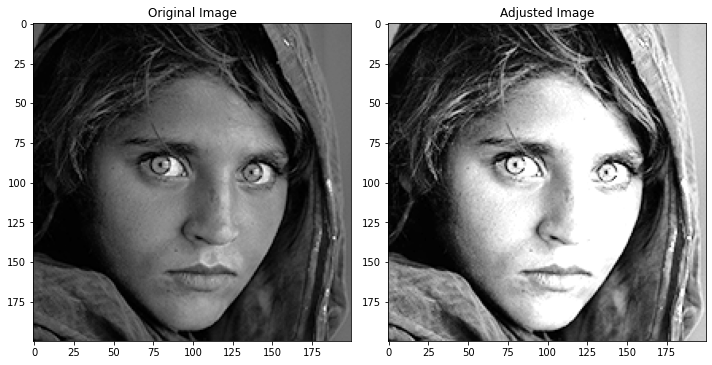

In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def adjust_brightness_contrast(image_array, alpha, beta):
    # Adjust contrast and brightness of the image array. Converting to floating point to
    # avoid overflow and underflow losses.
    temp = image_array.astype('float32')
    
    # Adjust contrast by multiplying each pixel value
    temp *= alpha
    
    # Adjust brightness by adding to every value.
    temp += beta

    # Clip values to be in the range [0, 255]
    temp = np.clip(temp, 0, 255)
    
    return temp.astype('uint8')

# Load Image
image = cv2.imread("Graphics/face.png")
# Convert image_data to grayscale
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


adjusted_image_data = adjust_brightness_contrast(image, 1.5, 50) 
 
# Plotting original and adjusted images side-by-side
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(adjusted_image_data, cmap="gray")
plt.title('Adjusted Image')

plt.tight_layout()
plt.show()

### Gamma Correction (Non-Linear)

Gamma correction is used to adjust the brightness and contrast of digital images. It's a nonlinear operation that encodes and decodes luminance values in an image.

The formula for gamma correction is:

$$ O = I^\gamma $$

Where:
- $ O $ is the output pixel value after gamma correction.
- $ I $ is the normalized input pixel value, usually in the range [0, 1].
- $ \gamma $ is the gamma value.

Considering pixel values are typically in the range [0, 255], the formula can be expanded to:

$$ O = 255 \times \left(\frac{I}{255}\right)^\gamma $$

- If $\gamma < 1 $, the image is made brighter.
- If $ \gamma > 1 $, the image is made darker.


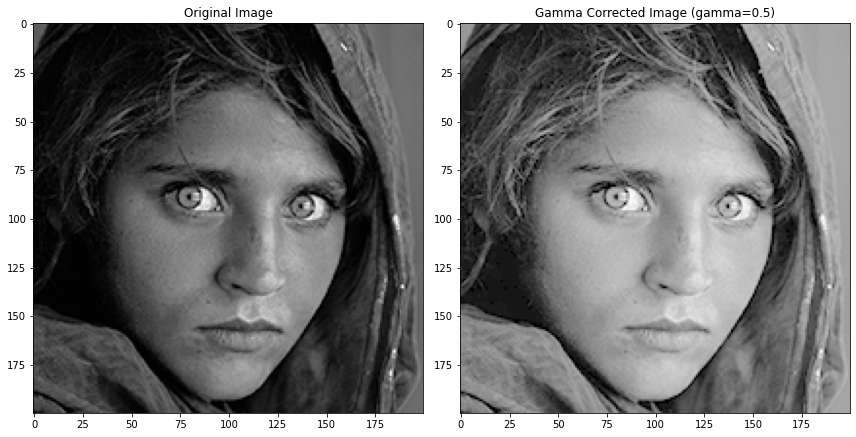

In [36]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gamma_correction(img, gamma):
    # Normalize the image to [0, 1], apply gamma correction, and then scale back to [0, 255]
    corrected = 255.0 * (img / 255.0) ** gamma
    # Return the corrected image
    return np.uint8(corrected)

# Load the image
image = cv2.imread("Graphics/face.png", cv2.IMREAD_GRAYSCALE)

# Display the original image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")

# Apply gamma correction and display the result
gamma = 0.5
corrected_image = gamma_correction(image, gamma)

plt.subplot(1, 2, 2)
plt.imshow(corrected_image, cmap="gray")
plt.title(f"Gamma Corrected Image (gamma={gamma})")
plt.tight_layout()
plt.show()
